<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" style="height:400px;" width=500px/></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h3 style="text-align: center;"><b>Домашнее задание: сегментация изображений</b></h3>

---

<h3 style="text-align: center;"><b>Условие</b></h3>

В качестве домашней работы предлагается улучшить сегментацию, сделанную на семинаре. В качестве основы для даталоэдера используйте функцию __keras_generator__. Попробуйте сделать следующие улучшения:
1. Брать случайный кроп, а не ресайзить исходное изображение. Попробуйте разные размеры кропов, на каких результат получается лучше? Кроп какого максимального размера помещается в вашу видеокарту?
2. Добавить аугментаций. Например, можно поворачивать картинки или добавлять случайный шум

Эти два пункта улучшения можно сделать с помощью библиотеки __albumentations__ https://github.com/albu/albumentations . Пример использования можно посмотреть в конце семинарского ноутбука.

In [1]:
1+1

2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

In [5]:
PATH ="/content/gdrive/My Drive/dlschool/[11]segmentation/"
df = pd.read_csv(PATH + 'data/train_masks.csv')
df.shape

(5088, 2)

In [0]:
from albumentations import (
    CLAHE, RandomRotate90, Transpose, RandomCrop, Resize, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, HorizontalFlip, OneOf, Compose, PadIfNeeded, LongestMaxSize, PadIfNeeded, ElasticTransform,Cutout
)

def strong_aug(p=1.0):
    return Compose([
        ShiftScaleRotate(shift_limit=0.125, scale_limit=0.2, rotate_limit=10, p=0.7, border_mode=cv2.BORDER_CONSTANT),
        RandomCrop(256, 256),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.3),

    ],
        p=p)

augmentation = strong_aug(p=1.0)


In [0]:
def keras_generator(gen_df, batch_size,preprocessing_fn):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('/content/gdrive/My Drive/dlschool/[11]segmentation/data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)
        
        x_batch = preprocessing_fn(x_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

Подумайте, нужно ли применять аугментации для валидационной выборки или это стоит делать только для тренировки? Возможно, следует добавить в аргументы __keras_generator__ флаг, который будет говорить, применять аугментации или нет.
3. В качестве модели машинного обучения предлагается взять либо модель с семинара, либо какую-нибудь готовую реализацию, например из __segmentation_models__ https://github.com/qubvel/segmentation_models . Пример использования:

In [8]:
pip install segmentation_models

     |████████████████████████████████| 51kB 992kB/s 
     |████████████████████████████████| 81kB 3.1MB/s 


In [0]:
train_df = df[:4000]
val_df = df[4000:]

In [0]:
img_name, mask_rle = train_df.iloc[4]

img = cv2.imread('/content/gdrive/My Drive/dlschool/[11]segmentation/data/train/{}'.format(img_name))
mask = rle_decode(mask_rle)

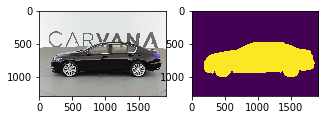

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
axes[0].imshow(img)
axes[1].imshow(mask[..., 0])

plt.show()

In [0]:
for x, y in keras_generator(train_df, 16):
    break

In [0]:
x.shape

(16, 256, 256, 3)

In [0]:
y.shape

(16, 256, 256, 1)

In [14]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
batch_size = 16
# prepare data
#x_train, y_train = keras_generator(train_df, batch_size)
#x_val, y_val = keras_generator(val_df, batch_size)
#x, y = x_train, y_train

#preprocessing_fn = get_preprocessing('resnet34')
#x = preprocessing_fn(x)

# prepare model
model = Unet(backbone_name='resnet34', encoder_weights='imagenet')
model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
85524480/85521592 [==============================] - 1s 0us/step


In [0]:
best_w = keras.callbacks.ModelCheckpoint('segnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('segnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]

In [16]:
preprocessing_fn = get_preprocessing('resnet34')
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size,preprocessing_fn),
              steps_per_epoch=100,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size,preprocessing_fn),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
100/100 [==============================] - 374s 4s/step - loss: 0.1292 - binary_accuracy: 0.9756 - val_loss: 0.0514 - val_binary_accuracy: 0.9855
Epoch 2/3
100/100 [==============================] - 236s 2s/step - loss: 0.0259 - binary_accuracy: 0.9928 - val_loss: 0.0216 - val_binary_accuracy: 0.9935
Epoch 3/3
100/100 [==============================] - 172s 2s/step - loss: 0.0160 - binary_accuracy: 0.9949 - val_loss: 0.0165 - val_binary_accuracy: 0.9943


In [0]:
for x, y in keras_generator(train_df, 16,preprocessing_fn):
    break

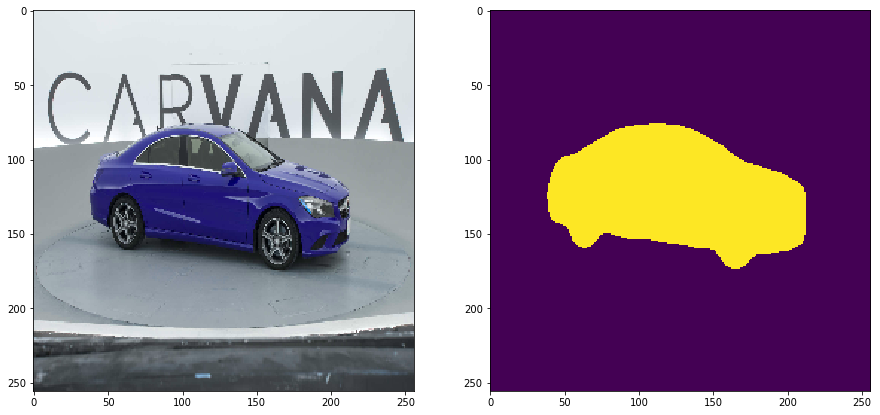

In [27]:
pred = model.predict(x)#.shape
im_id = 7
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] >0.5)

plt.show()

В качестве базового энкодера на семинаре использовался __resnet50__. Поэкспериментируйте с разными энкодерами, например, __VGG16__, __densenet121__. Какой дает лучшее качество?

Итак, вы обучили модель предсказывать кропы, например, размера 256x256, качество мерили тоже на кропах. Но как исходная цель - нужно уметь делать предсказания на всю картинку. Как решить проблему и есть ли она вообще? Первый приходящий в голову вариант - можно проходиться по картинке окном в 256x256 пикселей и сохранять предсказания на всю большую картинку. Но можно сделать проще, если ответить на вопрос: работает ли полностью сверточная сеть на картинках произвольного размера(с добиванием до кратности паддингами)? Почему не работали сети для классификации?

4. Напоследок, можете попробовать технику под названием __Test Time Augmentation__. Сделайте предсказание картинки, сохраните его. Попробуйте сделать flip картинки, и предсказать флипнутое изображение. Что будет если усреднить результаты этих двух предсказаний? Улучшится ли качество?

---

<h3 style="text-align: center;"><b>Ваше решение</b></h3>

In [0]:
#добавил аугментацию в генератор батчей
def keras_generator(gen_df, batch_size,preprocessing_fn,augmentation=augmentation):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('/content/gdrive/My Drive/dlschool/[11]segmentation/data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            #добавил аугментацию
            data = {'image': img.astype('uint8'), 'mask': mask}
            augmented = augmentation(**data)
            crop_img, crop_mask = augmented["image"], augmented["mask"]
            
            x_batch += [crop_img]
            y_batch += [crop_mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)
        
        x_batch = preprocessing_fn(x_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [0]:
for x, y in keras_generator(train_df, 16,preprocessing_fn):
    break

In [30]:
x.shape

(16, 256, 256, 3)

In [31]:
y.shape

(16, 256, 256, 1)

In [0]:
batch_size = 16
model = Unet(backbone_name='resnet34', encoder_weights='imagenet')
model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

In [33]:
preprocessing_fn = get_preprocessing('resnet34')
model.fit_generator(keras_generator(train_df, batch_size,preprocessing_fn),
              steps_per_epoch=100,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size,preprocessing_fn),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/3
100/100 [==============================] - 157s 2s/step - loss: 0.0909 - binary_accuracy: 0.9746 - val_loss: 0.7501 - val_binary_accuracy: 0.8353
Epoch 2/3
100/100 [==============================] - 108s 1s/step - loss: 0.0243 - binary_accuracy: 0.9920 - val_loss: 0.0241 - val_binary_accuracy: 0.9917
Epoch 3/3
100/100 [==============================] - 101s 1s/step - loss: 0.0241 - binary_accuracy: 0.9912 - val_loss: 0.0386 - val_binary_accuracy: 0.9862


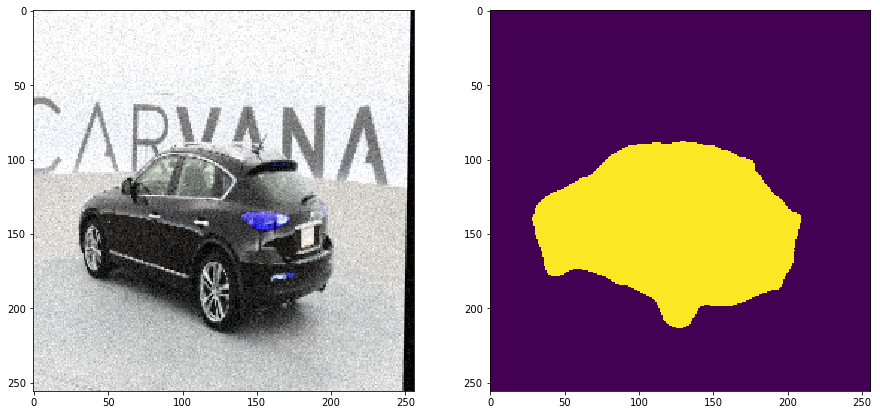

In [41]:
pred = model.predict(x)#.shape
im_id = 13
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] >0.5)

plt.show()

Во время первой эпохи качество в начале было 0.6 на валидации и потом выросло до 0.83, за время 2ой эпохи модель с кропнутыми данными опередила по качеству модель с нормальными данными, обучавшуюся 3 эпохи. Правда потом качество ухудушилось, возможно модель переобучилась или это какие-то флуктуации и стоит еще попробовать пару эпох посмотреть, что будет дальше.

Попробуем VGG16 и не будем кропать валидационные данные, посмотрим, что получится.

In [0]:
def keras_generator(gen_df, batch_size,preprocessing_fn,augmentation=augmentation):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('/content/gdrive/My Drive/dlschool/[11]segmentation/data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            #добавил аугментацию
            if augmentation:
              data = {'image': img.astype('uint8'), 'mask': mask}
              augmented = augmentation(**data)
              img, mask = augmented["image"], augmented["mask"]
            
                   
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)
        
        x_batch = preprocessing_fn(x_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

VGG16 с аугментацией на трейне и валидации

In [43]:
batch_size = 16
model = Unet(backbone_name='vgg16', encoder_weights='imagenet')
model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

58892288/58889256 [==============================] - 1s 0us/step


In [46]:
preprocessing_fn = get_preprocessing('vgg16')
model.fit_generator(keras_generator(train_df, batch_size,preprocessing_fn),
              steps_per_epoch=100,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size,preprocessing_fn,augmentation = augmentation),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/3
100/100 [==============================] - 91s 914ms/step - loss: 0.2134 - binary_accuracy: 0.9181 - val_loss: 2.7733 - val_binary_accuracy: 0.7870
Epoch 2/3
100/100 [==============================] - 81s 809ms/step - loss: 0.1493 - binary_accuracy: 0.9432 - val_loss: 1.2224 - val_binary_accuracy: 0.7857
Epoch 3/3
100/100 [==============================] - 80s 804ms/step - loss: 0.1543 - binary_accuracy: 0.9400 - val_loss: 2.0144 - val_binary_accuracy: 0.7888


VGG16 с аугментацией на трейне и валидацией на исходных данных

In [47]:
batch_size = 16
model = Unet(backbone_name='vgg16', encoder_weights='imagenet')
model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])
preprocessing_fn = get_preprocessing('vgg16')
model.fit_generator(keras_generator(train_df, batch_size,preprocessing_fn),
              steps_per_epoch=100,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size,preprocessing_fn,augmentation = augmentation),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/3
100/100 [==============================] - 92s 923ms/step - loss: 0.3045 - binary_accuracy: 0.8840 - val_loss: 0.9226 - val_binary_accuracy: 0.7736
Epoch 2/3
100/100 [==============================] - 77s 766ms/step - loss: 0.1917 - binary_accuracy: 0.9268 - val_loss: 2.0040 - val_binary_accuracy: 0.7863
Epoch 3/3
100/100 [==============================] - 79s 791ms/step - loss: 0.1554 - binary_accuracy: 0.9401 - val_loss: 0.6105 - val_binary_accuracy: 0.7896


Качество вышло примерно одинаковое и архитектура VGG показала себя хуже чем реснет за 3 эпохи

Попробуем densenet121

In [50]:
# трейн и валидация аугментированные
batch_size = 8
model = Unet(backbone_name='densenet121', encoder_weights='imagenet')
model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])
preprocessing_fn = get_preprocessing('densenet121')
model.fit_generator(keras_generator(train_df, batch_size,preprocessing_fn),
              steps_per_epoch=200,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size,preprocessing_fn,augmentation = augmentation),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/3
200/200 [==============================] - 126s 630ms/step - loss: 0.1009 - binary_accuracy: 0.9704 - val_loss: 1.3435 - val_binary_accuracy: 0.7877


KeyboardInterrupt: ignored

Денснет оказался очень тяжелый для колаба, но результаты тоже хуже, чем у реснета.

In [0]:
model =0